# CSE 510 Reinforcement Learning Spring 2020 Assignment 2
# Value Function Approximation - Part FOUR (BreakOut)
## Srisai Karthik Neelamraju 50316785, neelamra@buffalo.edu

## Double Deep Q-learning for solving OpenAI Breakout

### Importing the required libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import gym
from gym.wrappers import FrameStack, AtariPreprocessing
import random
from collections import deque
import time
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Defining the double deep Q-learning agent class

In [0]:
class DDQNAgent:
    def __init__(self, env, eps=1.0, eps_decay=0.9999, eps_min=0.01, alpha=0.01, gamma=0.99, batch_size=32, MAX_EXP=100000):
        # initializing a double deep Q-learning agent
        self.env = env
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.input_dims = self.env.observation_space.shape
        self.n_actions = self.env.action_space.n
        self.experiences = deque(maxlen=MAX_EXP)
        self.init_qnets()

    def init_qnets(self):
        self.primary_qnet = tf.keras.Sequential()
        self.primary_qnet.add(tf.keras.layers.Conv2D(filters=32, kernel_size=8, activation="relu", padding="valid", input_shape=self.input_dims, data_format="channels_first"))
        self.primary_qnet.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="valid", data_format="channels_first"))
        self.primary_qnet.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="valid", data_format="channels_first"))
        self.primary_qnet.add(tf.keras.layers.Flatten())
        self.primary_qnet.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        optimizer = tf.keras.optimizers.Adam(lr=self.alpha)
        self.primary_qnet.compile(loss="mean_squared_error", optimizer=optimizer)

        self.target_qnet = tf.keras.Sequential()
        self.target_qnet.add(tf.keras.layers.Conv2D(filters=32, kernel_size=8, activation="relu", padding="valid", input_shape=self.input_dims, data_format="channels_first"))
        self.target_qnet.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="valid", data_format="channels_first"))
        self.target_qnet.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="valid", data_format="channels_first"))
        self.target_qnet.add(tf.keras.layers.Flatten())
        self.target_qnet.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        self.target_qnet.set_weights(self.primary_qnet.get_weights())

    def store_experience(self, state, action, reward, next_state, done):
        self.experiences.append({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})

    def policy(self, state):
        # epsilon-greedy action selection
        state = state.reshape(1, self.input_dims[0], self.input_dims[1], self.input_dims[2])
        if np.random.uniform() < self.eps:
            return np.random.choice([0, 2, 3])
        return np.argmax(self.primary_qvals(state))

    def primary_qvals(self, state):
        state = state.reshape(1, self.input_dims[0], self.input_dims[1], self.input_dims[2])
        return self.primary_qnet.predict(state)

    def target_qvals(self, state):
        state = state.reshape(1, self.input_dims[0], self.input_dims[1], self.input_dims[2])
        return self.target_qnet.predict(state)

    def train_qnet(self):
        # sampling a minibatch of experiences
        if len(self.experiences) < self.batch_size:
            return
        batch = random.sample(self.experiences, self.batch_size - 1)
        batch.append(self.experiences[-1])

        # training the Q-network on these experiences
        states = []
        q_targets = []
        for exp in batch:
            state = exp['state']
            states.append(state)
            qval = exp['reward']
            if not exp['done']:
                qval += self.gamma * self.target_qvals(exp['next_state'])[0][np.argmax(self.primary_qvals(exp['next_state']))]
            q_target = self.primary_qvals(state)
            q_target[0][exp['action']] = qval
            q_targets.append(q_target.reshape(self.n_actions))
        self.primary_qnet.fit(np.array(states), np.array(q_targets), verbose=False)

### Training the DDQN agent on the OpenAI BreakOut environment

In [0]:
# initializing the BreakoutNoFrameskip-v4 environment
env_brkout = gym.make('BreakoutNoFrameskip-v4')
env_brkout = AtariPreprocessing(env_brkout, frame_skip=4, screen_size=84, terminal_on_life_loss=True, scale_obs=True)
env_brkout = FrameStack(env_brkout, 4)

# initializing the Double DQN agent
ddqn_agent = DDQNAgent(env_brkout, alpha=0.00001, batch_size=8)

MAX_STEPS = 2500
n_upd_target = 10000
total_score = 0
avg_scores = []
last100_avg_scores = []
last100 = deque(maxlen=100)
count = 0

episodes = 4000
for episode in range(1, episodes + 1):
    env_brkout.reset()
    state, _, _, _ = env_brkout.step(1)
    state = np.array(state)
    done = False
    score = 0
    n_steps = 0
    while not done:
        action = ddqn_agent.policy(state)
        next_state, reward, done, _ = env_brkout.step(action)
        next_state = np.array(next_state)
        ddqn_agent.store_experience(state, action, reward, next_state, done)
        ddqn_agent.train_qnet()
        np.copyto(state, next_state)
        score += reward
        n_steps += 1
        if n_steps == MAX_STEPS:
            break
        if count % n_upd_target == 0:
            ddqn_agent.target_qnet.set_weights(ddqn_agent.primary_qnet.get_weights())
    total_score += score
    avg_scores.append(total_score/episode)
    last100.append(score)
    last100_avg_scores.append(np.mean(last100))
    print("Episode: " + str(episode) + ", Score: " + str(score) + ", Avg Score: " + str(avg_scores[-1]) + ", Avg Score (Last 100 runs): " + str(last100_avg_scores[-1]))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 1, Score: 0.0, Avg Score: 0.0, Avg Score (Last 100 runs): 0.0
Episode: 2, Score: 0.0, Avg Score: 0.0, Avg Score (Last 100 runs): 0.0
Episode: 3, Score: 0.0, Avg Score: 0.0, Avg Score (Last 100 runs): 0.0
Episode: 4, Score: 2.0, Avg Score: 0.5, Avg Score (Last 100 runs): 0.5
Episode: 5, Score: 0.0, Avg Score: 0.4, Avg Score (Last 100 runs): 0.4
Episode: 6, Score: 0.0, Avg Score: 0.3333333333333333, Avg Score (Last 100 runs): 0.3333333333333333
Episode: 7, Score: 0.0, Avg Score: 0.2857142857142857, Avg Score (Last 100 runs): 0.2857142857142857
Episode: 8, Score: 0.0, Avg Score: 0.25, Avg Score (Last 100 runs): 0.25
Episode: 9, Score: 0.0, Avg Score: 0.2222222222222222, Avg Score (Last 100 runs): 0.2222222222222222
Episode: 10, Score: 0.0, Avg Score: 0.2, Avg Score (Last 100 runs): 0.2
Episode: 11, Score: 0.0, Avg Score: 0.18181818181818182, Avg Score (Last 100 runs): 0.18181818181818182
Episode: 12, Score: 1.0, Avg Score: 0.25, Avg Score (Last 100 runs): 0.25
Episode: 13, Score:

### Visualizing the average scores while training the DDQN agent

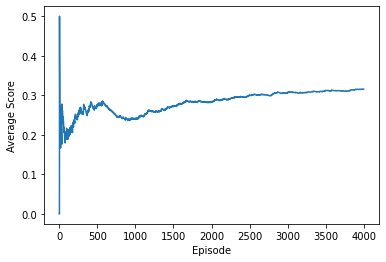

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.plot(avg_scores)

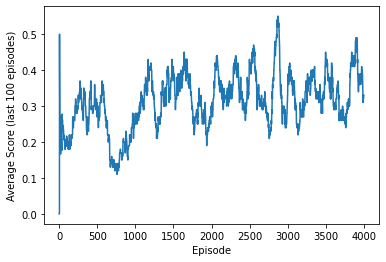

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Score (last 100 episodes)')
plt.plot(last100_avg_scores)

### Observing performance of the trained DDQN Agent for 100 episodes

In [0]:
# turning off the agent's exploration
ddqn_agent.eps = 0
ddqn_agent.eps_min = 0

test_last100 = []
test_last100_avg_scores = []
print("Testing the performance of the trained Double DQN Agent\n")

episodes = 100
for episode in range(1, episodes + 1):
    env_brkout.reset()
    state, _, _, _ = env_brkout.step(1)
    state = np.array(state)
    done = False
    score = 0
    while not done:
        action = ddqn_agent.policy(state)
        next_state, reward, done, _ = env_brkout.step(action)
        next_state = np.array(next_state)
        np.copyto(state, next_state)
        score += reward
    test_last100.append(score)
    test_last100_avg_scores.append(np.mean(test_last100))
    print("Episode: " + str(episode) + ", Score: " + str(score))

print("Avg Score over 100 test episodes: " + str(np.mean(test_last100)))

Testing the performance of the trained Double DQN Agent

Episode: 1, Score: 1.0
Episode: 2, Score: 0.0
Episode: 3, Score: 0.0
Episode: 4, Score: 0.0
Episode: 5, Score: 0.0
Episode: 6, Score: 0.0
Episode: 7, Score: 0.0
Episode: 8, Score: 0.0
Episode: 9, Score: 0.0
Episode: 10, Score: 0.0
Episode: 11, Score: 0.0
Episode: 12, Score: 0.0
Episode: 13, Score: 0.0
Episode: 14, Score: 0.0
Episode: 15, Score: 0.0
Episode: 16, Score: 0.0
Episode: 17, Score: 0.0
Episode: 18, Score: 0.0
Episode: 19, Score: 0.0
Episode: 20, Score: 2.0
Episode: 21, Score: 0.0
Episode: 22, Score: 0.0
Episode: 23, Score: 0.0
Episode: 24, Score: 0.0
Episode: 25, Score: 0.0
Episode: 26, Score: 0.0
Episode: 27, Score: 0.0
Episode: 28, Score: 0.0
Episode: 29, Score: 0.0
Episode: 30, Score: 0.0
Episode: 31, Score: 0.0
Episode: 32, Score: 2.0
Episode: 33, Score: 0.0
Episode: 34, Score: 0.0
Episode: 35, Score: 0.0
Episode: 36, Score: 0.0
Episode: 37, Score: 2.0
Episode: 38, Score: 0.0
Episode: 39, Score: 0.0
Episode: 40, Sco

### Visualizing the average scores while testing the DDQN agent

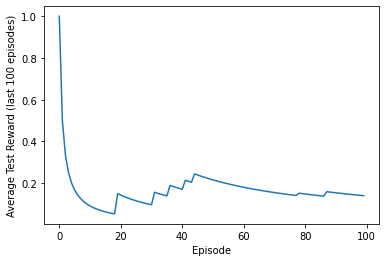

In [0]:
plt.xlabel('Episode')
plt.ylabel('Average Test Reward (last 100 episodes)')
plt.plot(test_last100_avg_scores)